# Лабораторная 2 "Horse or Human with ResNet"
# Выполннл студент группы М19-ИВТ-3
# Суворкинн Павел

# План:
## 1) Монтирование диска
## 2) Распаковка архивов
## 3)Загрузка ResNet
## 4) Импорт библиотек
## 5) Путь к файлам, инициализация флагов и переменных
## 6) Построение модели ResNet 152 v2
## 7) Создание генератора изображений
## 8) Создание callback
## 9) Компиляция и обучение модели
## 10) Сохранение модели и весов
## 11) Отрисовка графиков точности и потерь 
## 12) Тестирование нейросети


## 1) Монтирование гугл диска

In [ ]:
# Монтирование гугл диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##2) Разархивация файлов

In [ ]:
# На диск предварительно загружен архив с dataset
# Распаковка архива и вложенных архивов
#import zipfile
#with zipfile.ZipFile('/content/drive/My Drive/LAB_2/HoH.zip', 'r') as zip_ref_1:
#    zip_ref_1.extractall('/content/drive/My Drive/LAB_2/')
#with zipfile.ZipFile('/content/drive/My Drive/LAB_2/test.zip', 'r') as zip_ref_2:
#    zip_ref_2.extractall('/content/drive/My Drive/LAB_2/')


 ## 3) Загрузка ResNet 

In [ ]:
# pip install resnet

 ## 4) Импорт библиотек

In [ ]:
# Импорт необходимых библиотек
%tensorflow_version 2.x
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import tensorflow.keras
import keras
import numpy as np
import os
from PIL import Image
from imutils import paths
from matplotlib.pyplot import imshow
import tensorflow.keras
from keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from keras.applications.resnet_v2 import ResNet152V2

 ## 5) Путь к файлам, инициализация флагов и переменных

In [ ]:
train_path = "/content/drive/My Drive/LAB_2/horse-or-human/train"
val_path = "/content/drive/My Drive/LAB_2/horse-or-human/validation"
x_size = 300
y_size = 300
batch_size = 30
img_width, img_height = 150, 150 
input_shape = (img_width, img_height,3)
tr_ratio = .05
FIT = True

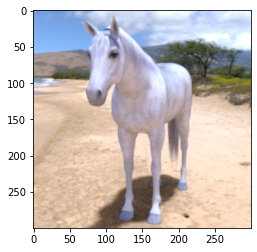

In [ ]:
img_path = train_path+'/horses/horse01-0.png'
image = cv2.cvtColor(cv2.imread(cv2.os.path.join(img_path)), cv2.COLOR_BGR2RGB)
imshow(image)

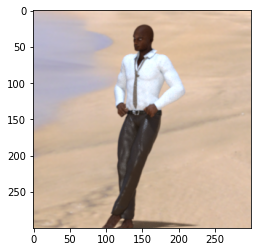

In [ ]:
img_path = train_path+'/humans/human05-01.png'
image = cv2.cvtColor(cv2.imread(cv2.os.path.join(img_path)), cv2.COLOR_BGR2RGB)
imshow(image)

 ## 6) Построение модели ResNet 152 v2

In [ ]:
RN152V2 = ResNet152V2(input_shape=(300, 300, 3),
                      weights='imagenet', # Использование весов предобученных на Imagenet
                      include_top=False) # Первый слой - НЕ полносвязный 

x = RN152V2.output
x = GlobalAveragePooling2D()(x) # Добавляем слой в модель

nb_classes = 2 
predictions = Dense(nb_classes, activation='softmax')(x)
model = Model(RN152V2.input, predictions)
model.summary()

234553344/234545216 [==============================] - 2s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 152, 152, 64) 0           conv1_conv[0][0]                 
____________________

## 7) Создание генератора изображений

In [ ]:
for layer in RN152V2.layers:
    layer.trainable = False

# Генерирует батчи новых данных в реальном времени
train_gen_data = ImageDataGenerator(rescale=1. / 255, # Коэффициент масштабирования
                                    rotation_range=tr_ratio, # Диапазон градусов для вращений
                                    shear_range=tr_ratio, # Угол сдвига против часовой стрелки в градусах
                                    zoom_range=tr_ratio, # Диапазон случайного увеличения
                                    cval=tr_ratio, # Значение, используемое для точек за пределами границ
                                    horizontal_flip=False, # Произвольно переворачивает входы по горизонтали
                                    vertical_flip=False) # Произвольно переворачивает входы по вертикали

val_data_gen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_gen_data.flow_from_directory(train_path,
                                                     target_size=(img_width, img_height),
                                                     batch_size=batch_size,
                                                     class_mode='categorical')

val_generator = val_data_gen.flow_from_directory(val_path,
                                                   target_size=(img_width, img_height),
                                                   batch_size=batch_size,
                                                   class_mode='categorical')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## 8) Создание callback

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_accuracy', # Параметр, который необходимо контролировать
                                patience=5, # Количество эпох без улучшения, после которых обучение будет остановлено
                                verbose=0)


In [ ]:
checkpoint = ModelCheckpoint('/content/drive/My Drive/LAB_2/best_weights/best_weights.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

## 9) Компиляция и обучение модели

In [ ]:
model.compile(optimizer='nadam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
if FIT == True:
  history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=20,
                    validation_data=val_generator,
                    validation_steps=val_generator.n // batch_size,
                    verbose=1,
                    callbacks=[early_stopping_callback, checkpoint] )
else:
    hist = model.load_weights("/content/drive/My Drive/LAB_2/RN152V2_weights.h5")

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.9759
Epoch 00001: val_accuracy improved from -inf to 0.96667, saving model to /content/drive/My Drive/LAB_2/best_weights/best_weights.h5
34/34 [==============================] - 324s 10s/step - loss: 0.0766 - accuracy: 0.9759 - val_loss: 0.0778 - val_accuracy: 0.9667
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9980
Epoch 00002: val_accuracy improved from 0.96667 to 0.97500, saving model to /content/drive/My Drive/LAB_2/best_weights/best_weights.h5
34/34 [==============================] - 16s 459ms/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 0.0664 - val_accuracy: 0.9750
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9960
Epoch 00003: val_accuracy did not improve from 0.97500
34/34 [==============================] - 13s 369ms/step - loss: 0.0064 - accuracy: 0.9960 - val_loss: 0.0904 - val_accuracy: 0.9625
E

## 10) Сохранение модели и весов

In [ ]:
model.save_weights("/content/drive/My Drive/LAB_2/RN152V2_weights.h5")
model.save("/content/drive/My Drive/LAB_2/RN152V2_model.h5")

## 11) Отрисовка графиков точности и потерь 

In [ ]:
class Graph:
  def __init__(self, epochs):
    self.epochs = epochs
  def draw(self, data, data2, data_label, data2_label):
    plt.figure(figsize=(20,5))
    plt.plot(history.history[data], color = 'b', label=data_label)
    plt.plot(history.history[data2], color= 'r', label=data2_label)
    plt.legend()
    plt.show()
    plt.clf()

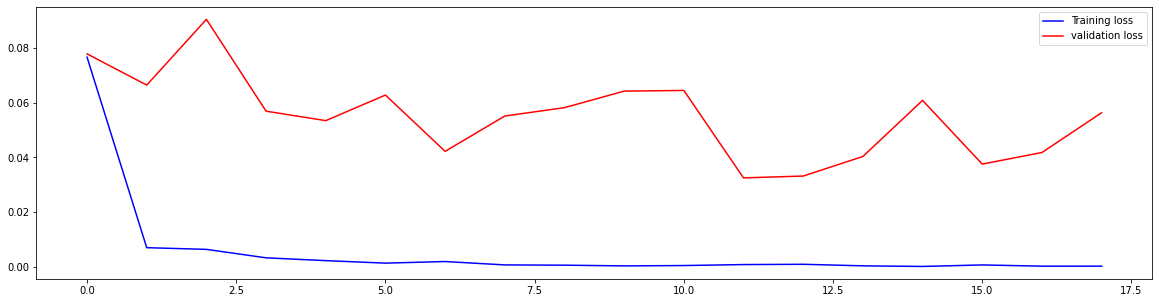

<Figure size 432x288 with 0 Axes>

In [ ]:
curve = Graph(20)
curve.draw('loss','val_loss','Training loss','validation loss')

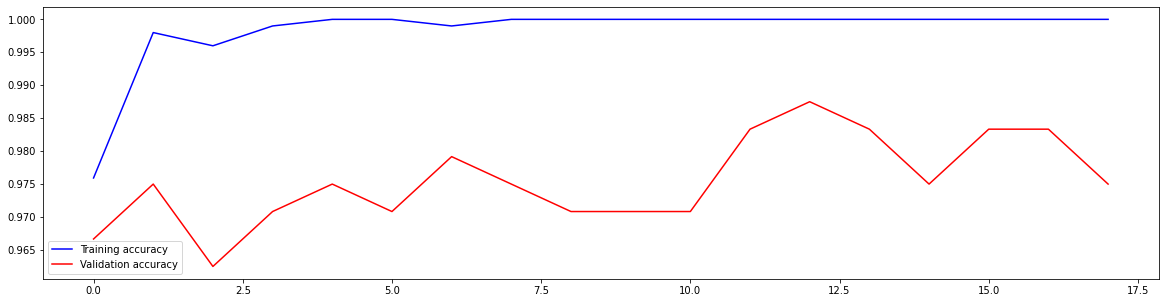

<Figure size 432x288 with 0 Axes>

In [ ]:
curve.draw('accuracy','val_accuracy',"Training accuracy","Validation accuracy")

## 12) Тестирование нейросети

(981, 736, 3)

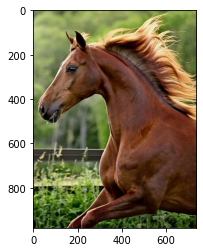

In [ ]:
#img_path = '/content/drive/My Drive/LAB_2/test/humans/HU2.jpg'
img_path = '/content/drive/My Drive/LAB_2/test/horses/HS1.jpg'
image = cv2.cvtColor(cv2.imread(cv2.os.path.join(img_path)), cv2.COLOR_BGR2RGB)
imshow(image)
image.shape

(300, 300, 3)

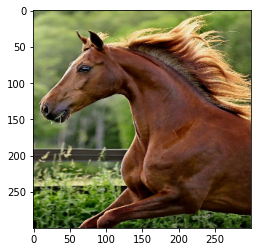

In [ ]:
img = cv2.resize(image, (300, 300))
imshow(img)
img.shape

In [ ]:
img = np.expand_dims(img, 0)

In [ ]:
# define function for input preprocessing
from skimage.transform import resize
from keras.applications.imagenet_utils import preprocess_input
def preprocess(x):
    x = resize(x, (300,300), mode='constant') * 255
    x = preprocess_input(x)
    if x.ndim == 3:
        x = np.expand_dims(x, 0)
    return x

In [ ]:
img = preprocess(img)

In [ ]:
res = model.predict(img) 
print(res)

[[0. 1.]]


In [ ]:
# make prediction and decode it
from keras.applications.imagenet_utils import decode_predictions
pred_title = decode_predictions(res, top=1)

# print result
print(pred_title)

ValueError: ignored